In [10]:


pd.set_option('display.max_columns', None)

df=pd.read_csv('current_qb.csv')


# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import lightgbm as lgb




import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import LeaveOneOut



import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
df.columns

Index(['passer_player_name', 'week', 'season', 'posteam', 'defteam',
       'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack',
       'pass_touchdown', 'passing_yards', 'pass_attempts',
       'def_complete_pass_allowed', 'def_avg_ints', 'def_avg_qb_hit',
       'def_avg_sack', 'def_avg_td_allowed', 'def_avg_yards_allowed',
       '2023_qb_completion_avg', '2023_qb_yards_avg', '2023_qb_attempts_avg',
       '2023_qb_int_avg'],
      dtype='object')

In [14]:
columns_to_keep = ['passing_yards', 'def_complete_pass_allowed', 'def_avg_ints', 'def_avg_qb_hit',
       'def_avg_sack', 'def_avg_td_allowed', 'def_avg_yards_allowed',
       '2023_qb_completion_avg', '2023_qb_yards_avg', '2023_qb_attempts_avg',
       '2023_qb_int_avg']

In [91]:
df2=df[columns_to_keep]

In [92]:
X = df2.drop('passing_yards', axis=1)
y = df2['passing_yards']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [94]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

In [25]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

LinearRegression()

In [27]:
y_pred = lm.predict(X_test_scaled)

In [32]:
lm.score(X_train_scaled, y_train)


0.016564590107004507

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [47]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 62.07171220160094
Mean Squared Error (MSE): 6036.149750539682
Root Mean Squared Error (RMSE): 77.69266214089772


First model is off by 77 yards on average

In [50]:
mean_y_baseline = np.mean(y_test)
y_baseline = np.full_like(y_test, fill_value=mean_y_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_baseline))
print(f'RMSE for Baseline (Predicting Mean of Y): {rmse_baseline}')

RMSE for Baseline (Predicting Mean of Y): 78.79861156397361


In [54]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(r2)


0.027873291791385646


Trying with one player

In [86]:
df2= df[df['passer_player_name'] == 'M.Stafford']

In [87]:
df2=df2[columns_to_keep]

In [88]:
X = df2.drop('passing_yards', axis=1)
y = df2['passing_yards']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

lm2 = LinearRegression()
lm2.fit(X_train_scaled, y_train)


LinearRegression()

In [89]:
y_pred = lm2.predict(X_test_scaled)

In [90]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 66.27555430162984
Mean Squared Error (MSE): 5916.396583721092
Root Mean Squared Error (RMSE): 76.9181160957618


## Trying XGBoost

In [95]:
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train_scaled, y_train,)
dtest_reg = xgb.DMatrix(X_test_scaled, y_test)

In [109]:
# Set parameters
params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': 3}

# Train the model
model = xgb.train(params, dtrain_reg, num_boost_round=100)

# Make predictions
predictions = model.predict(dtest_reg)



In [111]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 60.30687110740822
Mean Squared Error (MSE): 6318.126022480185
Root Mean Squared Error (RMSE): 79.48664052833146


## LightGBM

In [122]:




# Create LightGBM datasets
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

# Set parameters for LightGBM

params = {
    'task': 'train',
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learning_rage': 0.05,
    'metric': {'l2', 'l1'},
    'verbose': -1
}


# Train the LightGBM model
num_round = 100  # Number of boosting rounds
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
rmse = mse**0.5
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error: 7212.926695902929
Root Mean Squared Error (RMSE): 84.92895087014162


Feature Importance Scores:
2023_qb_completion_avg: 4014714.9154663086
2023_qb_yards_avg: 3864260.7651367188
def_avg_qb_hit: 2448255.934814453
2023_qb_attempts_avg: 2415940.3349609375
def_complete_pass_allowed: 2354068.1076660156
def_avg_ints: 2124619.8989868164
def_avg_sack: 2058227.7080688477
2023_qb_int_avg: 1977426.7131347656
def_avg_yards_allowed: 1853989.9470214844
def_avg_td_allowed: 1683198.4774169922


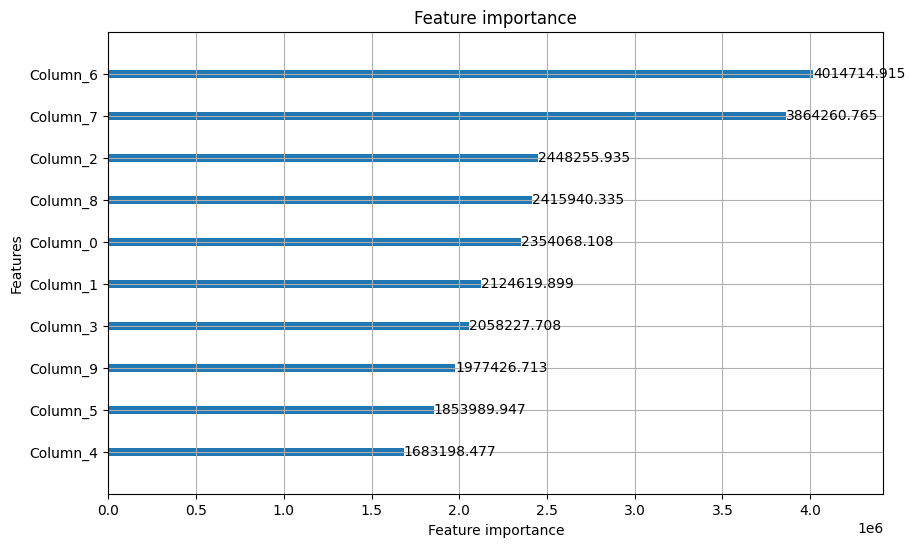

In [119]:
feature_importance = bst.feature_importance(importance_type='gain')

# Map feature names to indices
feature_names = X_test.columns
feature_indices = {feature: idx for idx, feature in enumerate(feature_names)}

# Sort features by importance
sorted_feature_indices = sorted(feature_indices.items(), key=lambda x: feature_importance[x[1]], reverse=True)

# Print feature importance scores
print("Feature Importance Scores:")
for feature, idx in sorted_feature_indices:
    print(f"{feature}: {feature_importance[idx]}")

# Plot feature importance
lgb.plot_importance(bst, importance_type='gain', max_num_features=10, figsize=(10, 6))
plt.show()